# Traffic Road Signs Recognition 
***
In this notebook, we will building pipeline to classify the traffic signs from the German Traffic Sign Benchmarks. There are several different types of traffic signs like speed limits, no entry, traffic signals, turn left or right, children crossing, no passing of heavy vehicles, etc. So, Traffic signs classification is the process of identifying which class a traffic sign belongs to.

The starting model is a convolutional network based on the LeNet architecture by Yann LeCun. LeNet was originally designed for handwritten and machine-printed character recognition.

The project is explained in the following sections :
   - Data Exploratory Analysis
   - Preprocessing
   - Model Implementation
   - Training
   - Model Evaluation
   - Convolutional layers visualization
   - Most important parts of images for prediction visualization using *GradCAM*

## Traffic  Road Signs Dataset  
For this project, we are using the public dataset available at Kaggle : [German Traffic Sign Recognition Benchmark](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) 

The dataset contains more than 50,000 images of different traffic signs. It is further classified into 43 different classes. The dataset is quite varying, some of the classes have many images while some classes have few images. The size of the dataset is around 300 MB. The dataset has a train folder which contains images inside each class and a test folder which we will use for testing our model.

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
import sklearn
import os
import time
import itertools
import cv2
import seaborn as sns
import warnings
import tqdm
import math
from tensorflow.contrib.layers import flatten
import matplotlib.gridspec as gridspec
#Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style('whitegrid')

## Dataset Exploration 
Our ‘train’ folder contains 43 folders each representing a different class. The range of the folder is from 0 to 42. 

The shape of data is (39209, 30, 30, 3) which means that there are 39,209 images of size 30×30 pixels and the last 3 means the data contains colored images (RGB value). We should also remap path because of kaggle converts folder to lowercase mode.

In [2]:
dataset_dir = './dataset'
meta_info = os.path.join(dataset_dir, 'Meta.csv')
train_csv_path = os.path.join(dataset_dir, 'Train.csv')
test_csv_path = os.path.join(dataset_dir, 'Test.csv')
n_out = 43
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

In [3]:
#Load Dataset 
trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)
#Remap path 
trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))
#Show random samples
trainDf.sample(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
11210,61,62,5,6,56,57,7,/home/mehdi/Classification/dataset/train/7/000...
25809,62,55,6,6,56,50,18,/home/mehdi/Classification/dataset/train/18/00...
34557,53,55,5,6,48,50,35,/home/mehdi/Classification/dataset/train/35/00...
3625,55,52,6,5,50,47,2,/home/mehdi/Classification/dataset/train/2/000...
32801,38,35,6,6,33,30,31,/home/mehdi/Classification/dataset/train/31/00...


### Classes Distribution 
The easiest way to discover dataset balance is to build histogram. We consider to use seaborn library based on matplotlib for pretty data visualization.

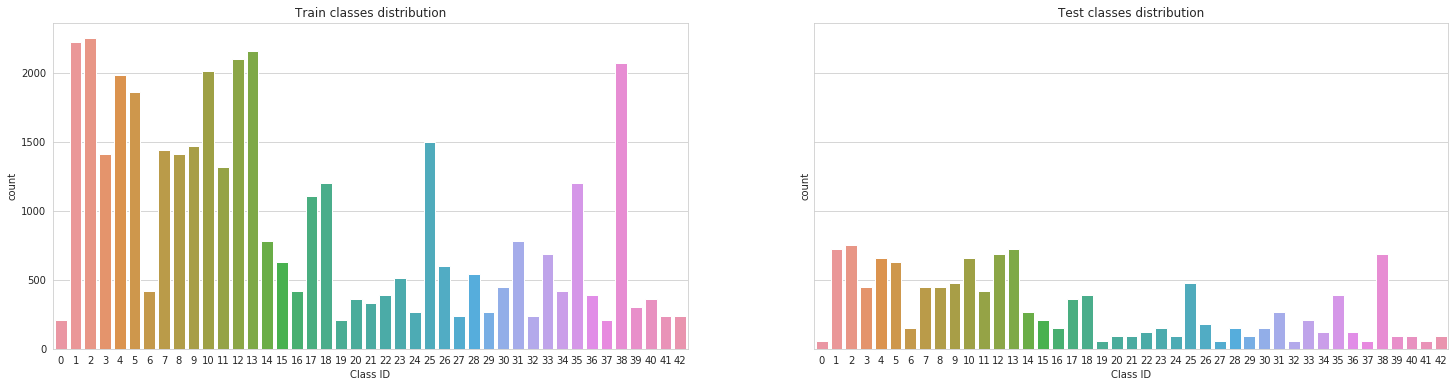

In [4]:
#Plot Train & Test distributions
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

The class distribution in train and test sets look very similar. Even if we did not balance dataset, it is possible to obtain a reasonable accuracy for this particular testset. However, for new test sets with different class distributions, accuracy will go down. Therefore, we need to balance our training set later by data augmentation.

### Occuranes of different classes 

In [5]:
#Create pandas dataframe to load csv file
sign_name_df = pd.read_csv('labels.csv')
SIGN_NAMES = sign_name_df.ClassId.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head()

,Name
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [6]:
#Function for finding lables for class-id 
def get_name_from_label(label):
    #Transofrm a numeric label into the corresponding strring
    return sign_name_df.loc[label].SignName

In [7]:
#Show occurence
sign_name_df['Occurence'] = [sum(trainDf['ClassId'] == c) for c in range(n_out)]
sign_name_df.sort_values('Occurence', ascending=False)

,Name,Occurence
ClassId,,
2,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
13,Yield,2160
12,Priority road,2100
38,Keep right,2070
10,No passing for vechiles over 3.5 metric tons,2010
4,Speed limit (70km/h),1980
5,Speed limit (80km/h),1860
25,Road work,1500


### Visualize Train Samples 
It is good idea to visualize samples in order to brief data exploration. Image visualization can help us to better understand our problem. Some solutions (such as histogram equalization) can be discovered by visual data exploration.

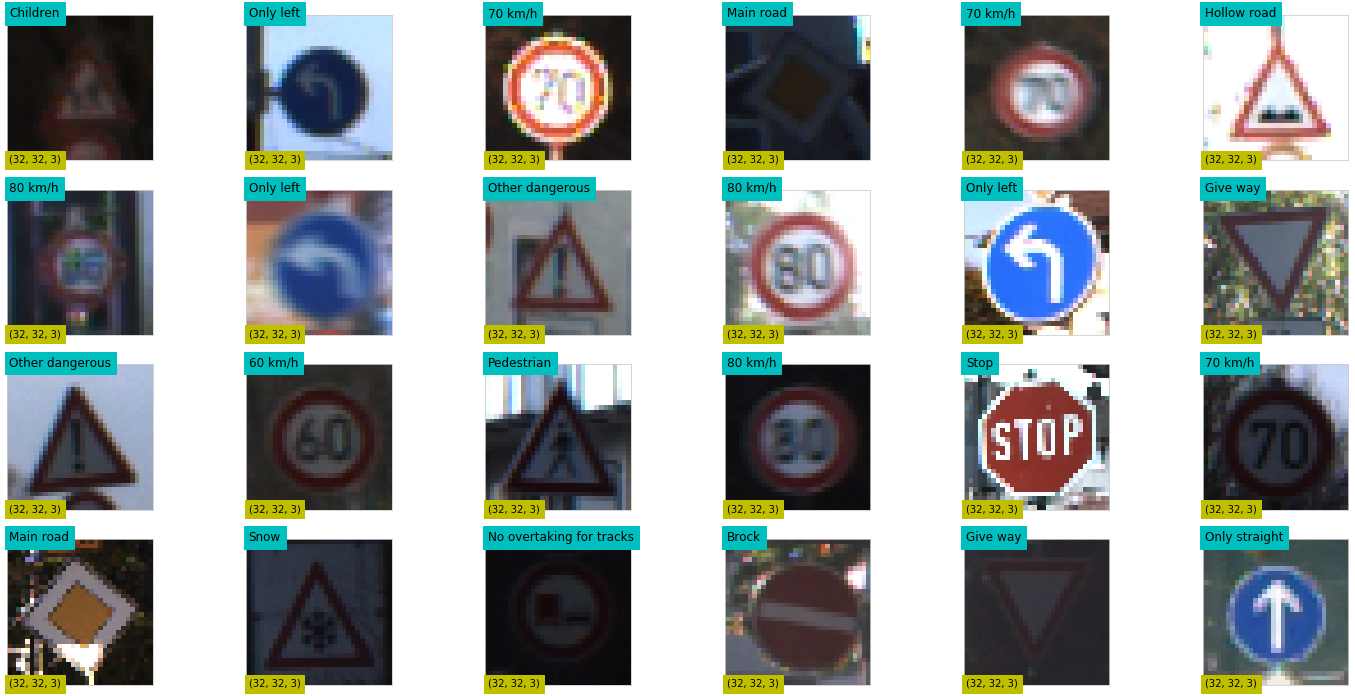

In [8]:
#Plot Train image samples
rows = 4
cols = 6
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
visualize = trainDf.sample(rows*cols)
idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(visualize["Path"].tolist()[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32,32))
        axs[i,j].imshow(img)
        axs[i,j].text(0, 0, '{}'.format(labels[int(visualize["ClassId"].tolist()[idx])]), color='k',backgroundcolor='c', fontsize=12) 
        axs[i,j].text(0, img.shape[0], '{}'.format(img.shape), color='k',backgroundcolor='y', fontsize=10)
        #axs[i,j].set_title(labels[int(visualize["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

## Preprocessing 
In this step, we will apply several preprocessing steps to the input images to achieve the best results. We will define utils for loading tensors, augmentation & other data manipulation. 

In [9]:
#Define utils for loading tensors, augmentation & other data manipulation.
img_load_size = (32,32)
zero_img = np.zeros([12,img_load_size[0], img_load_size[1], 3])
zero_label = np.zeros([12,1])

#Define Parse function
def parse_function(filename, label):
    image_string = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image.set_shape([None, None, 3])
    return filename, image, label

#Convert & resize images
def train_preprocess(filename, image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, img_load_size)
    return filename, image, label

#Data augmentation
def augmentate(filename, image, label):
    grad = tf.random.uniform(shape=[], minval=-0.3, maxval=0.3)
    dx = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    dy = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    image = tf.contrib.image.rotate(image, grad)
    image = tf.contrib.image.translate(image, translations=[dx, dy])
    
    return filename, image, label

#Equalizing histogram
def eq(img: np.ndarray):
    res = img.copy()
    res[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    res[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    res[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
    return res

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.to_float(image), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.to_float(pix_cnt - 1))
    px_map = tf.cast(px_map, tf.uint8)

    gth = tf.gather_nd(px_map, tf.cast(image, tf.int32))
    eq_hist = tf.expand_dims(gth, 2)
    return image

### Dataset Pipeline
Above we have prepared pandas DataFrame with all data. Now, let's create operaition for loading data using **tf.data.Dataset**.

In [11]:
#Loading dataset pipeline
tf.reset_default_graph()

epochs = 30
batch_size = 12
prefetch_count = 1
samples_train = len(trainDf)
samples_test = len(testDf)

dataset_train = tf.data.Dataset.from_tensor_slices((trainDf['Path'], trainDf['ClassId']))
dataset_train = dataset_train.shuffle(len(trainDf['Path']))
dataset_train = dataset_train.repeat(epochs)
dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_train = dataset_train.map(train_preprocess, num_parallel_calls=4)
dataset_train = dataset_train.map(augmentate, num_parallel_calls=4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(prefetch_count)

dataset_iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)

dataset_test = tf.data.Dataset.from_tensor_slices((testDf['Path'], testDf['ClassId']))
dataset_test = dataset_test.shuffle(len(testDf['Path']))
dataset_test = dataset_test.repeat(epochs+1)
dataset_test = dataset_test.map(parse_function, num_parallel_calls=4)
dataset_test = dataset_test.map(train_preprocess, num_parallel_calls=4)
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.prefetch(prefetch_count)


train_init_op = dataset_iterator.make_initializer(dataset_train)
test_init_op = dataset_iterator.make_initializer(dataset_test)

load_filename, load_img, load_label = dataset_iterator.get_next()

In [12]:
dataset_train.output_shapes

(TensorShape([Dimension(None)]),
 TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)]),
 TensorShape([Dimension(None)]))

### Visualize Preprocessed Images 

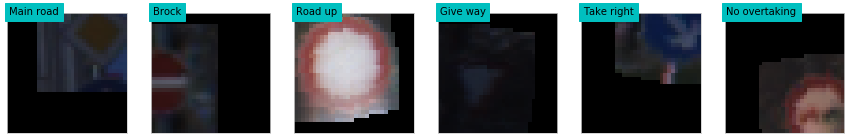

In [13]:
#Plot augmented images samples
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15, 6))
with tf.Session() as sess:
    sess.run(train_init_op)
    for j in range(6):
        i, l = sess.run([load_img, load_label])
        i = (i[0]*255).astype(np.uint8)
        ax[j].imshow(i)
        ax[j].text(0, 0, '{}'.format(labels[l[0]]), color='k',backgroundcolor='c', fontsize=10)
        #ax[j].set_title(labels[l[0]])
        ax[j].get_xaxis().set_visible(False)
        ax[j].get_yaxis().set_visible(False)

## Design Model Architecture  
In this step, we will design and implement a deep learning model that learns to recognize traffic signs from our dataset. <br>
We will use **Convolutional Neural Networks** to classify the images in our dataset. The reason behind choosing **CNN** is that they are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They automatically learn hierarchies of invariant features at every level from data. Our goal is to reach an accuracy of +95% on the validation set.

In [14]:
#Model graph defined using native tensorflow API.
#Also, we should defined some placeholders in order to have opportunity to load custom controled data into netwrok. 
dp_rate = tf.placeholder(dtype=tf.float32, shape=[], name='dp_rate')

img_placeholder = tf.placeholder(shape=[None, 32,32,3], dtype=tf.float32, name='img_placeholder')
label_placeholder = tf.placeholder(shape=[None, 1], dtype=tf.int64, name='label_placeholder')
manual_load = tf.placeholder(dtype=tf.bool, shape=[], name='manual_load_placeholder')

inp = net = tf.cond(manual_load, lambda: img_placeholder, lambda: load_img)
label = load_label

conv1 = net = tf.layers.conv2d(inputs=net, filters=16, 
                               kernel_size=(3,3), 
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)
conv2 = net = tf.layers.conv2d(inputs=net, filters=32, 
                               kernel_size=(3,3), 
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)

conv3 = net = tf.layers.conv2d(inputs=net, filters=32, 
                               kernel_size=(3,3), 
                               strides=(1,1),
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)
conv4 = net = tf.layers.conv2d(inputs=net, filters=64, 
                               kernel_size=(3,3), 
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)

net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

conv5 = net = tf.layers.conv2d(inputs=net, filters=64, 
                               kernel_size=(3,3),
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=128,
                               kernel_size=(3,3), 
                               strides=(1,1),
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)

conv5 = net = tf.layers.conv2d(inputs=net, filters=256, 
                               kernel_size=(3,3), 
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=400,
                               kernel_size=(3,3), 
                               strides=(1,1), 
                               activation=tf.nn.relu)
net = tf.layers.batch_normalization(inputs=net)

flatten1 = net = tf.layers.flatten(inputs=net)

dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
dense1 = net = tf.layers.dense(inputs=net, units=256)
logits = tf.layers.dense(inputs=net, units=43)

pred_classes = tf.argmax(logits, axis=1)
pred_probas = tf.nn.softmax(logits)

acc, acc_op = tf.metrics.accuracy(labels=label, predictions=pred_classes)
end_loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=label)

loss = end_loss

label_transpose = tf.transpose(label)
correct_prediction = tf.equal(pred_classes, label_transpose)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
confusion_matrix_op = tf.confusion_matrix(labels=label, predictions=pred_classes, num_classes=43)

opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training    
In this step, we'll run the training data through the training pipeline to train the model. <br> 
   - Before each epoch, shuffle the training set.
   - After each epoch, we measure the loss and accuracy of the validation set.
   - And after training, we will save the model.
   - A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
#Training pipeline
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
train_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0

for e in range(epochs):
    epoch_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    
    sess.run(train_init_op)
    for i in tqdm.tqdm_notebook(range(samples_train//batch_size), ascii=True, desc='Train epoch {}'.format(e)):
        _, _loss, _acc, mn = sess.run([opt, loss, accuracy, inp], feed_dict={dp_rate: 0.3, 
                                                                             manual_load: False, 
                                                                             img_placeholder: zero_img, 
                                                                             label_placeholder: zero_label})
        epoch_history['loss'].append(_loss)
        epoch_history['acc'].append(_acc)
        
    sess.run(test_init_op)
    for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test epoch {}'.format(e)):
        _loss, _acc = sess.run([loss, accuracy], feed_dict={dp_rate: 0, 
                                                            manual_load: False, 
                                                            img_placeholder: zero_img, 
                                                            label_placeholder: zero_label})
        epoch_history['val_loss'].append(_loss)
        epoch_history['val_acc'].append(_acc)
        
    train_history['loss'].append(np.mean(epoch_history['loss']))
    train_history['acc'].append(np.mean(epoch_history['acc']))
    train_history['val_loss'].append(np.mean(epoch_history['val_loss']))
    train_history['val_acc'].append(np.mean(epoch_history['val_acc']))
    
    print("------ EPOCH {} SUMMARY ------ \n Loss: {} Acc: {} \n Test Loss: {} Test Acc {}".format(e,
                                                                                                train_history['loss'][-1], 
                                                                                                train_history['acc'][-1],
                                                                                                train_history['val_loss'][-1], 
                                                                                                train_history['val_acc'][-1]))

    if train_history['val_acc'][-1] > best_acc:
        best_acc = train_history['val_acc'][-1]
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)

/home/mehdi/.virtualenvs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/home/mehdi/.virtualenvs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



------ EPOCH 0 SUMMARY ------ 
 Loss: 3.101736068725586 Acc: 0.13197633624076843 
 Test Loss: 2.8893916606903076 Test Acc 0.1985107660293579
Model saved in path: ./model.ckpt



------ EPOCH 1 SUMMARY ------ 
 Loss: 2.443037986755371 Acc: 0.2624732255935669 
 Test Loss: 1.9935957193374634 Test Acc 0.394328236579895
Model saved in path: ./model.ckpt



------ EPOCH 2 SUMMARY ------ 
 Loss: 1.848413348197937 Acc: 0.39712783694267273 
 Test Loss: 1.4538137912750244 Test Acc 0.5360423922538757
Model saved in path: ./model.ckpt



------ EPOCH 3 SUMMARY ------ 
 Loss: 1.5081721544265747 Acc: 0.4948984682559967 
 Test Loss: 1.091840147972107 Test Acc 0.6323668956756592
Model saved in path: ./model.ckpt



------ EPOCH 4 SUMMARY ------ 
 Loss: 1.24886953830719 Acc: 0.5816752910614014 
 Test Loss: 0.798660397529602 Test Acc 0.7630703449249268
Model saved in path: ./model.ckpt



------ EPOCH 5 SUMMARY ------ 
 Loss: 1.043357491493225 Acc: 0.6487603187561035 
 Test Loss: 0.595048189163208 Test Acc 0.8525031805038452
Model saved in path: ./model.ckpt



------ EPOCH 6 SUMMARY ------ 
 Loss: 0.8851640224456787 Acc: 0.7022497653961182 
 Test Loss: 0.4641858637332916 Test Acc 0.8960710167884827
Model saved in path: ./model.ckpt



------ EPOCH 7 SUMMARY ------ 
 Loss: 0.7761130928993225 Acc: 0.7379603385925293 
 Test Loss: 0.52768874168396 Test Acc 0.8863276243209839



------ EPOCH 8 SUMMARY ------ 
 Loss: 0.6910519003868103 Acc: 0.7671921253204346 
 Test Loss: 0.41766899824142456 Test Acc 0.9095373749732971
Model saved in path: ./model.ckpt



------ EPOCH 9 SUMMARY ------ 
 Loss: 0.6196612119674683 Acc: 0.7912712693214417 
 Test Loss: 0.40673503279685974 Test Acc 0.9218155741691589
Model saved in path: ./model.ckpt



------ EPOCH 10 SUMMARY ------ 
 Loss: 0.5660256743431091 Acc: 0.8110907673835754 
 Test Loss: 0.4469424784183502 Test Acc 0.9107256531715393



------ EPOCH 11 SUMMARY ------ 
 Loss: 0.5152742862701416 Acc: 0.8255280256271362 
 Test Loss: 0.3323189318180084 Test Acc 0.9337769746780396
Model saved in path: ./model.ckpt



------ EPOCH 12 SUMMARY ------ 
 Loss: 0.48661333322525024 Acc: 0.8367003202438354 
 Test Loss: 0.37405306100845337 Test Acc 0.9226869940757751



------ EPOCH 13 SUMMARY ------ 
 Loss: 0.44427764415740967 Acc: 0.8508825898170471 
 Test Loss: 0.32723468542099 Test Acc 0.9334600567817688



------ EPOCH 14 SUMMARY ------ 
 Loss: 0.4237841069698334 Acc: 0.8584328293800354 
 Test Loss: 0.3717411756515503 Test Acc 0.9316381812095642



------ EPOCH 15 SUMMARY ------ 
 Loss: 0.39248785376548767 Acc: 0.8658044934272766 
 Test Loss: 0.344209223985672 Test Acc 0.9397180080413818
Model saved in path: ./model.ckpt



------ EPOCH 16 SUMMARY ------ 
 Loss: 0.3787820041179657 Acc: 0.8737629055976868 
 Test Loss: 0.35896867513656616 Test Acc 0.928231954574585



------ EPOCH 17 SUMMARY ------ 
 Loss: 0.35775500535964966 Acc: 0.8794766068458557 
 Test Loss: 0.3528100252151489 Test Acc 0.9382129311561584



------ EPOCH 18 SUMMARY ------ 
 Loss: 0.3409639000892639 Acc: 0.8848077058792114 
 Test Loss: 0.431776225566864 Test Acc 0.9318757653236389



------ EPOCH 19 SUMMARY ------ 
 Loss: 0.3242088854312897 Acc: 0.8891184329986572 
 Test Loss: 0.42078956961631775 Test Acc 0.9432034492492676
Model saved in path: ./model.ckpt



------ EPOCH 20 SUMMARY ------ 
 Loss: 0.31398212909698486 Acc: 0.8961840867996216 
 Test Loss: 0.3628181517124176 Test Acc 0.9390842914581299



------ EPOCH 21 SUMMARY ------ 
 Loss: 0.2931288480758667 Acc: 0.9016937613487244 
 Test Loss: 0.36384227871894836 Test Acc 0.9457383155822754
Model saved in path: ./model.ckpt



------ EPOCH 22 SUMMARY ------ 
 Loss: 0.2871696352958679 Acc: 0.9026885628700256 
 Test Loss: 0.29843538999557495 Test Acc 0.9532635807991028
Model saved in path: ./model.ckpt



------ EPOCH 23 SUMMARY ------ 
 Loss: 0.28072458505630493 Acc: 0.907738983631134 
 Test Loss: 0.39916354417800903 Test Acc 0.9331432580947876



------ EPOCH 24 SUMMARY ------ 
 Loss: 0.2634902894496918 Acc: 0.9112845659255981 
 Test Loss: 0.24052214622497559 Test Acc 0.9580165147781372
Model saved in path: ./model.ckpt



------ EPOCH 25 SUMMARY ------ 
 Loss: 0.2631092667579651 Acc: 0.9144474864006042 
 Test Loss: 0.3561324179172516 Test Acc 0.9456590414047241



------ EPOCH 26 SUMMARY ------ 
 Loss: 0.25366777181625366 Acc: 0.91681969165802 
 Test Loss: 0.34046682715415955 Test Acc 0.9436787366867065



------ EPOCH 27 SUMMARY ------ 
 Loss: 0.24900169670581818 Acc: 0.9169217944145203 
 Test Loss: 0.32574939727783203 Test Acc 0.9523922204971313



------ EPOCH 28 SUMMARY ------ 
 Loss: 0.24196921288967133 Acc: 0.9209264516830444 
 Test Loss: 0.2826616168022156 Test Acc 0.9552440047264099



------ EPOCH 29 SUMMARY ------ 
 Loss: 0.23423601686954498 Acc: 0.9220743179321289 
 Test Loss: 0.45848503708839417 Test Acc 0.9387674927711487


### Training curves
Let's visualize accuracy and loss evolution.

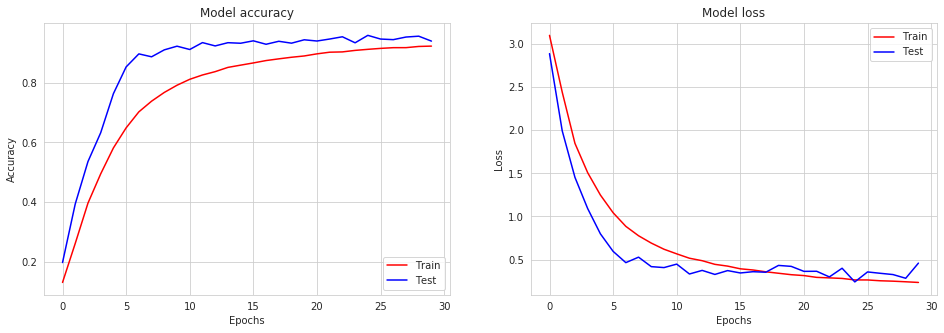

In [26]:
fig = plt.figure(figsize=(16, 5))

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_history['acc'], '-r')
plt.plot(train_history['val_acc'], '-b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], '-r')
plt.plot(train_history['val_loss'], '-b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

## Model Evaluation
### Model performance data preparation 
For futher model analysis we need some data. For this, we'll store all training statistic data in pandas DataFrame. Let's evaluate all test samples and store all information about prediction, probabilities and other information.

In [27]:
#Model performance data preparation
saver.restore(sess, "./model.ckpt")
sess.run(test_init_op)
confusion_matrix = np.zeros([43,43])
test_analys = trainDf.copy()
predictions = []
probabilities = []
analys = []

for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test best model'):
    _files, _predictions, _probas, _gts, _cm = sess.run([load_filename, pred_classes, pred_probas, load_label, confusion_matrix_op], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
    confusion_matrix += _cm
    for i in range(batch_size):
        sample_info = {'image': _files[i].decode(), 'prediction': int(_predictions[i]), 'gt': int(_gts[i]), 'gt_probas': _probas[i][_gts[i]],
                       'prediction_probas': _probas[i][_predictions[i]], 'prediction_type': 'Correct' if _gts[i] == _predictions[i] else 'Wrong'}
        for cls_id, j in enumerate(_probas[i]):
            sample_info['prob_{}'.format(cls_id)] = j
        analys.append(sample_info)

analys_df = pd.DataFrame(analys)

INFO:tensorflow:Restoring parameters from ./model.ckpt


/home/mehdi/.virtualenvs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [28]:
#Model evaluation analysis overview
analys_df.sample(5)

,image,prediction,gt,gt_probas,prediction_probas,prediction_type,prob_0,prob_1,prob_2,prob_3,...,prob_33,prob_34,prob_35,prob_36,prob_37,prob_38,prob_39,prob_40,prob_41,prob_42
509,/home/mehdi/Classification/dataset/test/12262.png,39,39,0.998034,0.998034,Correct,5.598737e-10,1.387304e-12,3.591725e-17,5.703507e-16,...,1.932843e-03,8.875549e-12,9.512409e-10,1.182835e-11,3.097709e-05,1.016275e-09,9.980341e-01,2.147088e-06,1.330746e-09,6.743361e-11
1055,/home/mehdi/Classification/dataset/test/05817.png,31,31,1.000000,1.000000,Correct,4.977096e-23,5.174518e-21,1.727937e-15,4.933901e-16,...,9.439310e-18,1.290476e-18,1.579794e-23,1.534592e-23,4.752937e-20,4.914095e-19,2.865693e-16,1.024724e-20,1.849636e-18,4.602040e-17
9643,/home/mehdi/Classification/dataset/test/02217.png,35,35,1.000000,1.000000,Correct,2.006394e-22,7.040157e-21,3.866449e-23,7.742865e-23,...,3.816084e-17,1.007654e-08,1.000000e+00,1.212671e-08,1.559320e-08,3.626780e-15,3.685779e-22,5.969560e-25,3.572735e-21,7.960614e-20
9256,/home/mehdi/Classification/dataset/test/12073.png,35,35,1.000000,1.000000,Correct,6.530989e-26,2.609927e-26,1.341897e-27,8.714761e-26,...,3.108555e-17,7.866354e-09,1.000000e+00,5.281701e-10,1.059261e-11,1.160737e-16,1.192253e-25,6.033792e-28,1.020027e-22,3.911373e-21
1163,/home/mehdi/Classification/dataset/test/08757.png,15,15,1.000000,1.000000,Correct,1.682117e-24,3.021373e-18,9.914047e-23,1.091171e-19,...,6.253209e-24,1.491675e-20,6.436270e-24,8.221538e-24,1.419380e-14,2.028221e-19,6.290262e-26,5.879108e-21,3.502866e-16,8.618064e-18


### Random Predictions 
Using informations computed above, we can visualize some random samples with their predictions. As we can see, it is impossible to recognize some pictures definitely by human, but network still generates correct predictions.

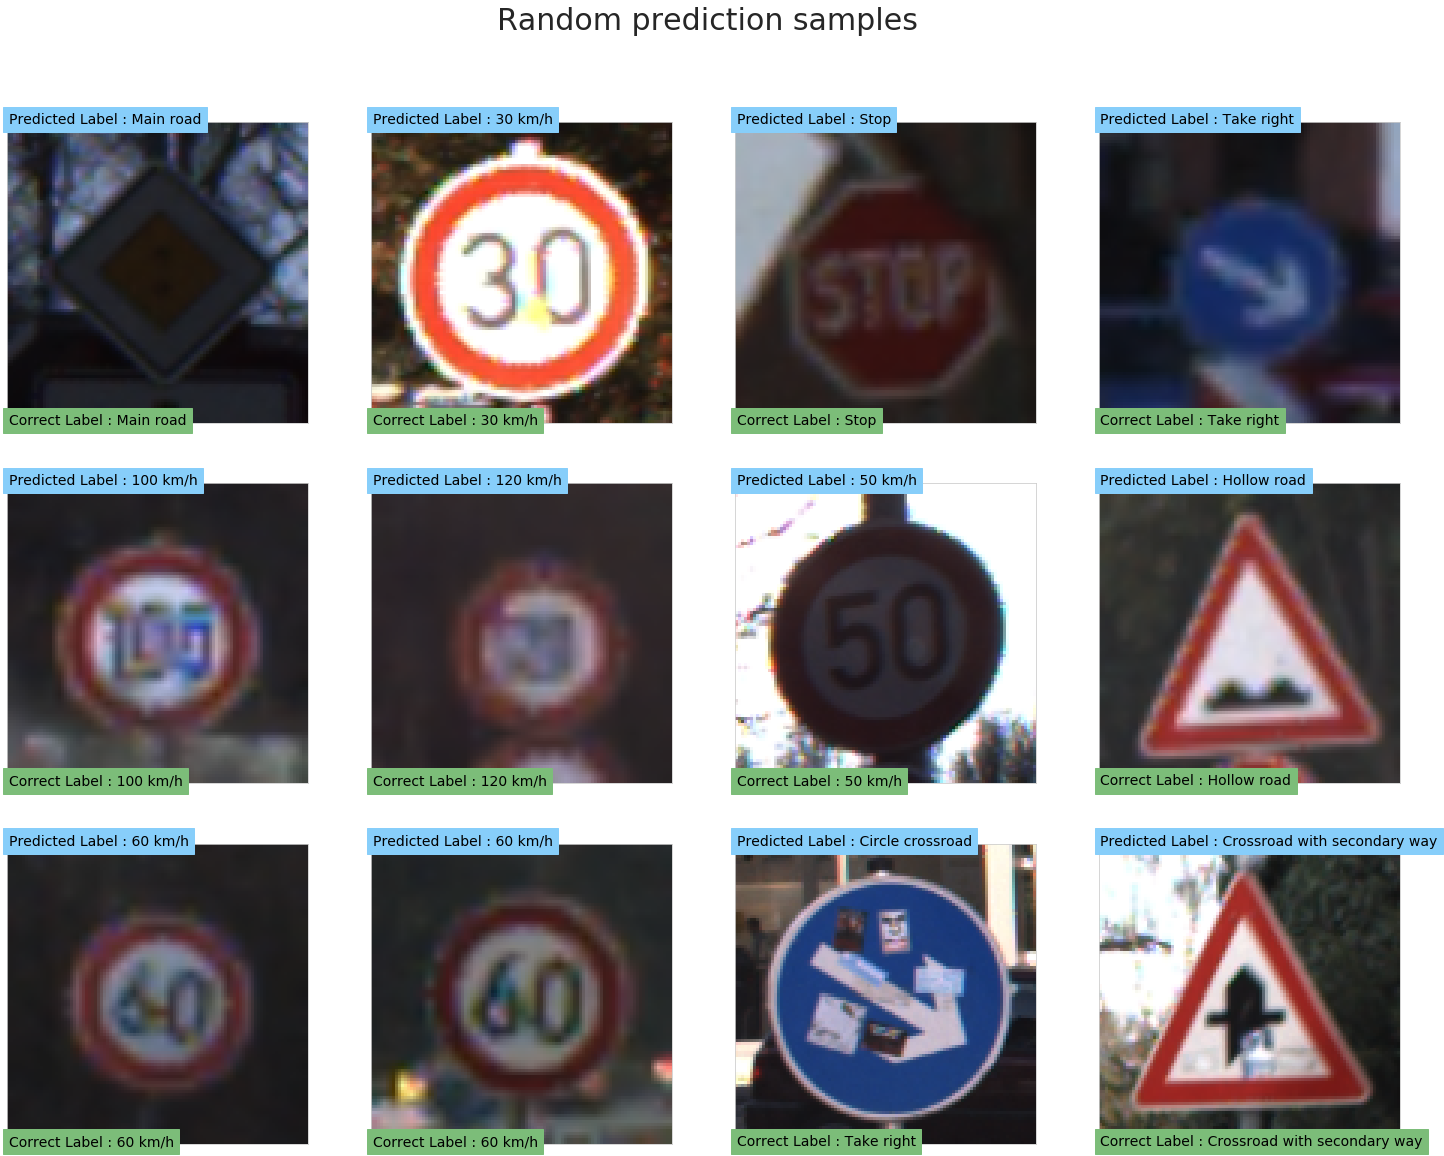

In [29]:
#Prediction visualization
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df.copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        axs[i,j].imshow(img)
        axs[i,j].text(0, 0, 'Predicted Label : {}'.format(labels[pred]), color='k',backgroundcolor='lightskyblue', fontsize=14) 
        axs[i,j].text(0, img.shape[0], 'Correct Label : {}'.format(labels[gt]), color='k',backgroundcolor='#7cbd79', fontsize=14)
        #axs[i,j].set_title('Predicted Label: {}\n Correct Label: {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Random prediction samples", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Wrong Predictions 
Our model can't achieve perfect accuracy (i.e. 100%). Let's visualize wrong predicted samples. Some of them have realy bad quality (resolution). Others have unexpected artifacts (such as extreme rotation, half hidden signs or shaddow). This situations wasn't present in train part, so our model have no idea how to deal with it.

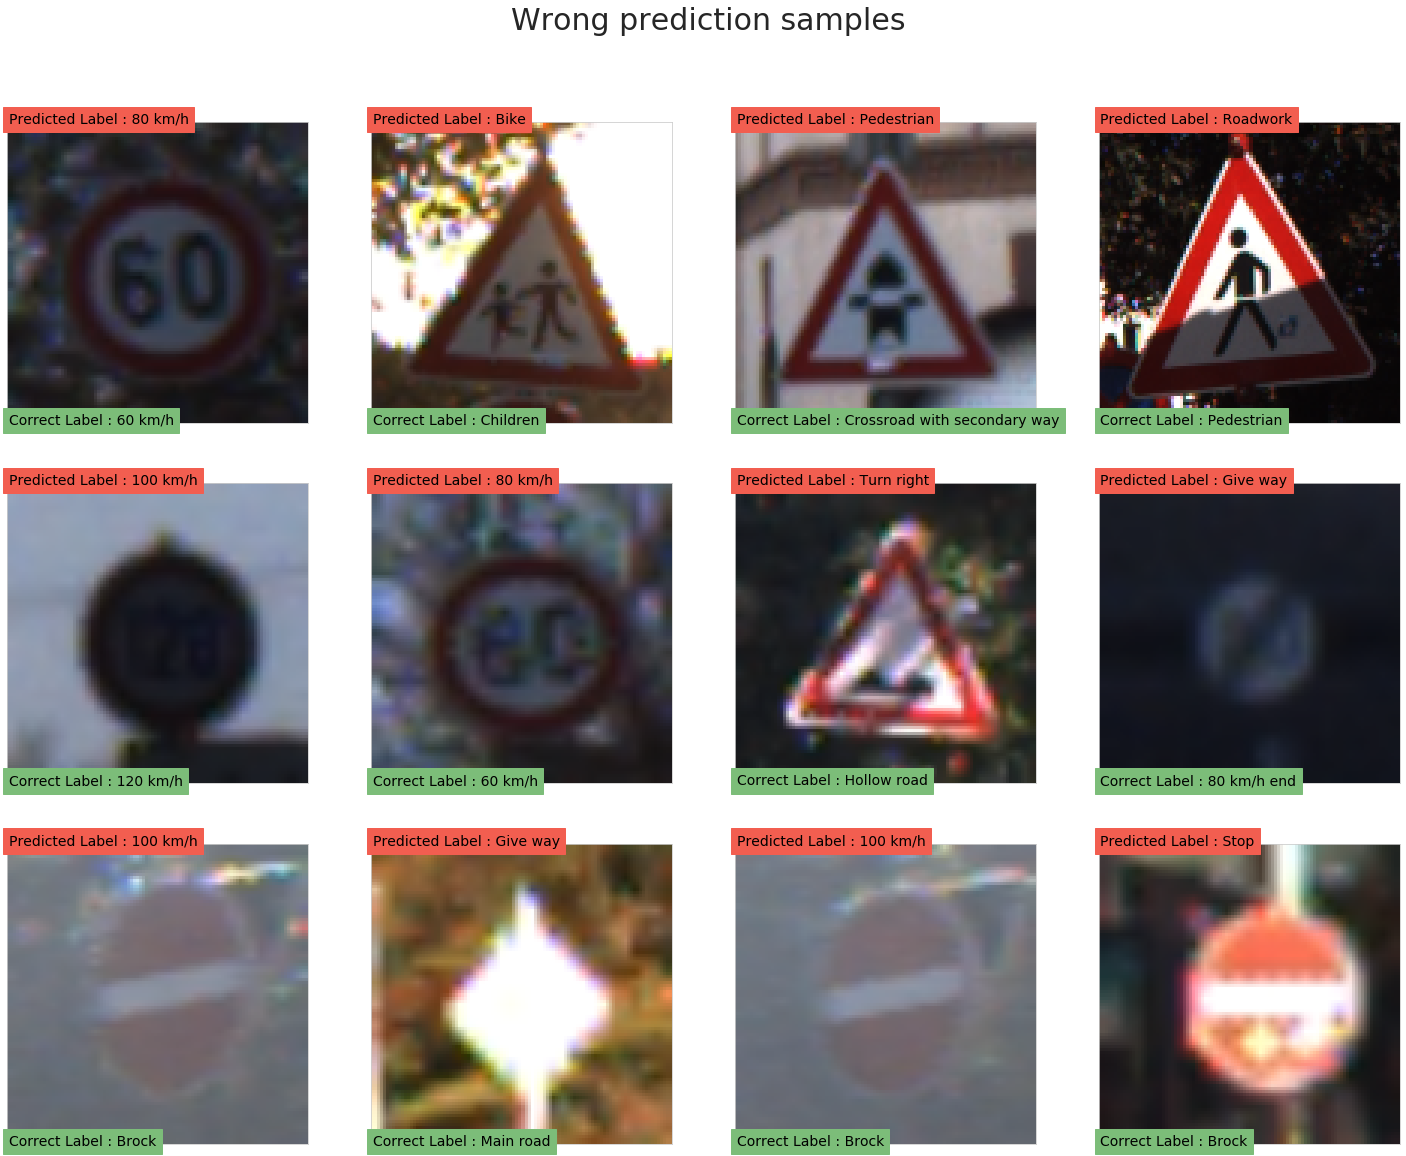

In [30]:
#Wrong prediction visualization
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df[analys_df['prediction_type'] == 'Wrong'].copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].text(0, 0, 'Predicted Label : {}'.format(labels[pred]), color='k',backgroundcolor='#f25e50', fontsize=14) 
        axs[i,j].text(0, img.shape[0], 'Correct Label : {}'.format(labels[gt]), color='k',backgroundcolor='#7cbd79', fontsize=14)
        #axs[i,j].set_title('Predicted: {}\n Correct Label: {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Wrong prediction samples", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Confusion Matrix 
Confusion matrix gives us additional information about accuracy distribution. It's naturally that our model may be confused in prediction "Pedestrian" and "Other dangerous" signs. Also, confusion matrix can give us idea about what to improve in our model.

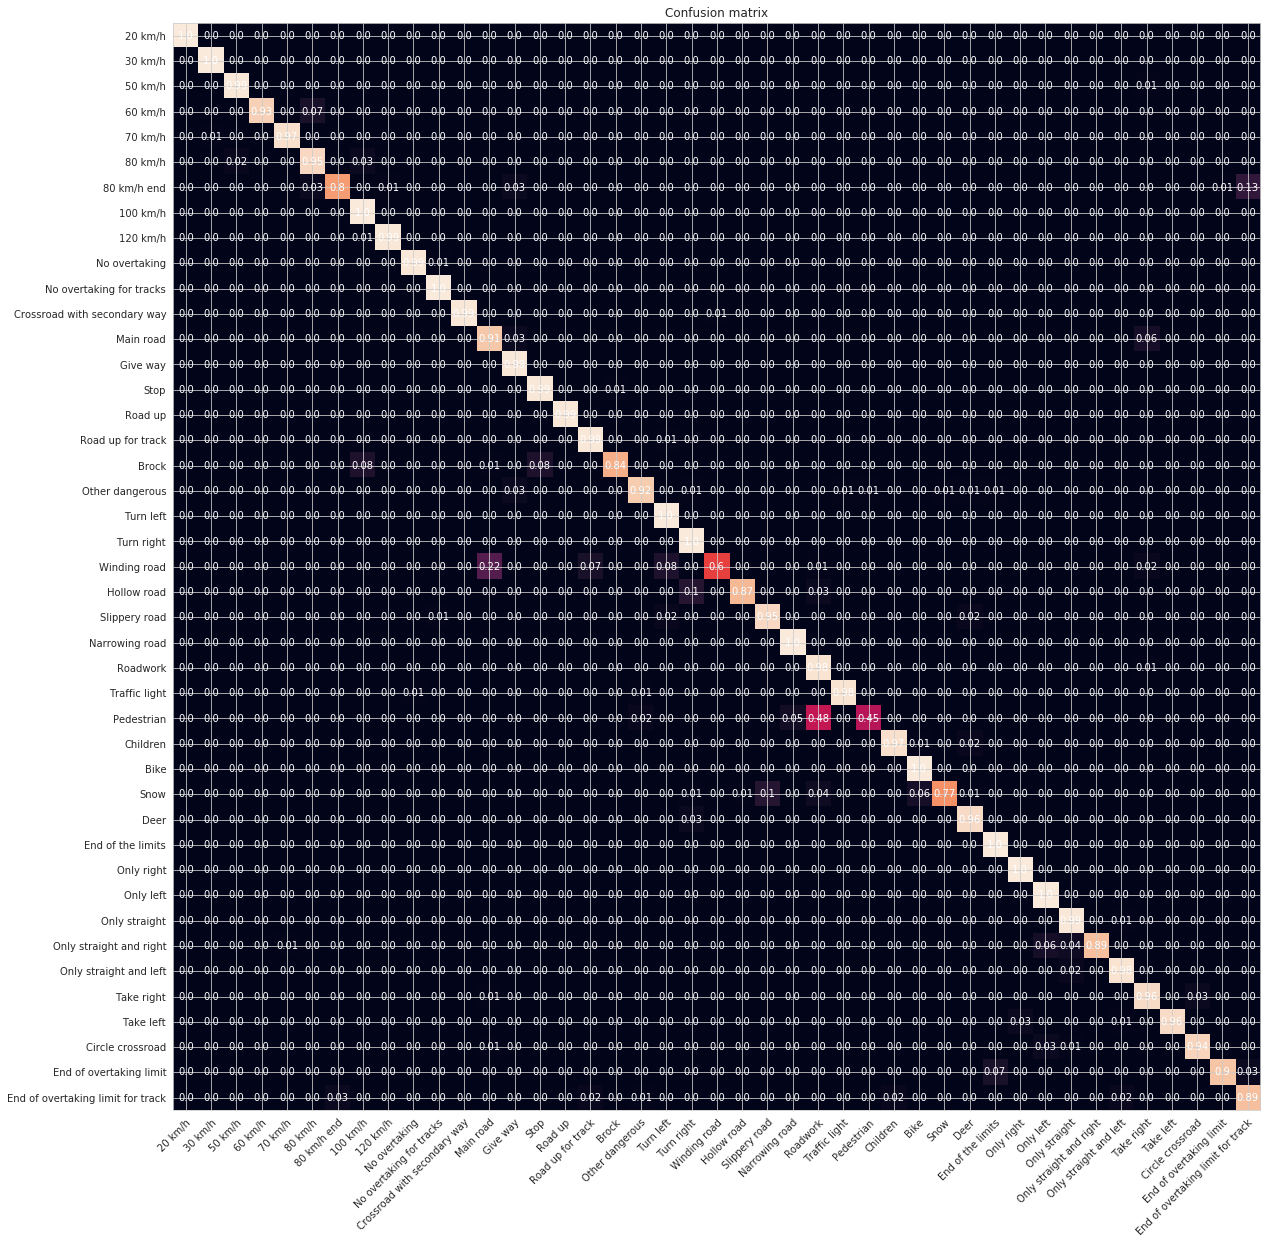

In [31]:
cm = confusion_matrix
f = np.sum(cm, axis=1)
normalized_cm = cm
for i in range(43):
    normalized_cm[i, :] /= sum(normalized_cm[i, :])

normalized_cm = np.round(normalized_cm, 2)
    
fig, ax = plt.subplots(1,1, figsize=((20, 20)))

ax.imshow(normalized_cm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, normalized_cm[i, j], ha="center", va="center", color="w")

ax.set_title('Confusion matrix');

### Distribution of prediction types

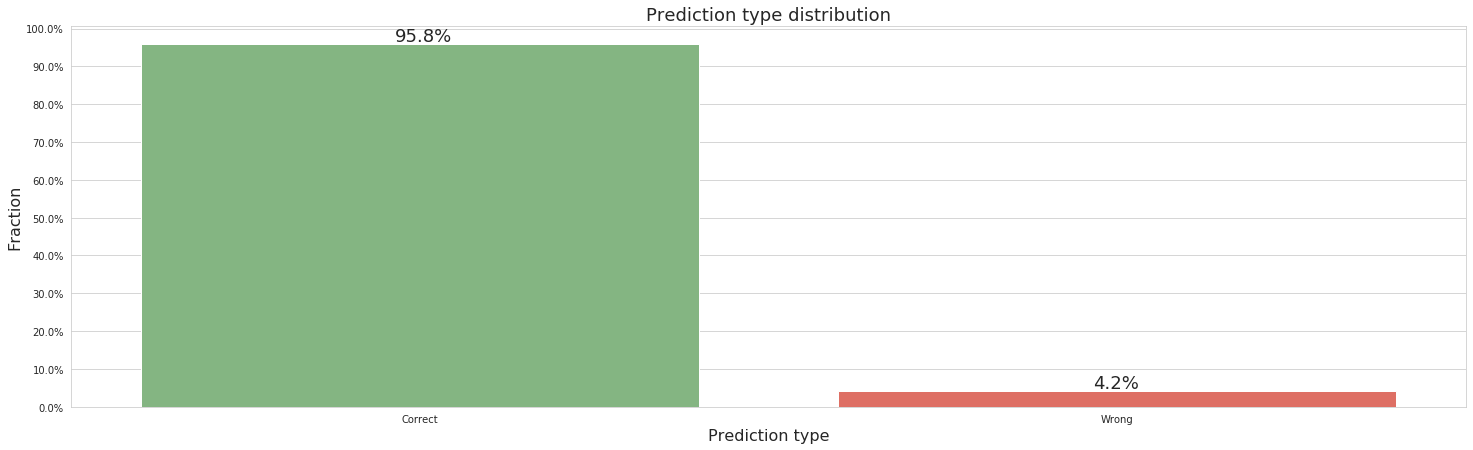

In [34]:
#Histogram of prediction types
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25, 7))

px = sns.countplot(x='prediction_type', data=analys_df, ax=axs, palette=['#7cbd79','#f25e50'])
axs.set_title('Prediction type distribution', fontsize=18)
axs.set_xlabel('Prediction type', fontsize=16)
axs.set_ylabel('Fraction', fontsize=16);

total = analys_df.shape[0]
for idx, p in enumerate(px.patches):
        px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.365, p.get_height()+100), fontsize=18)


px.yaxis.set_ticks(np.linspace(0, total, 11))
px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));

In [35]:
analys_df.prediction_type.value_counts()

Correct    12094
Wrong        530
Name: prediction_type, dtype: int64

### Accuracy by classes 
Confusion matrix produce very good visualization for understanding why some class is so bad in predictions, but it's no so convenient way to sum up numerrically how this class is good predicted. Below are histgrams of correctly and wrong predicted classes without correlation with other classes.

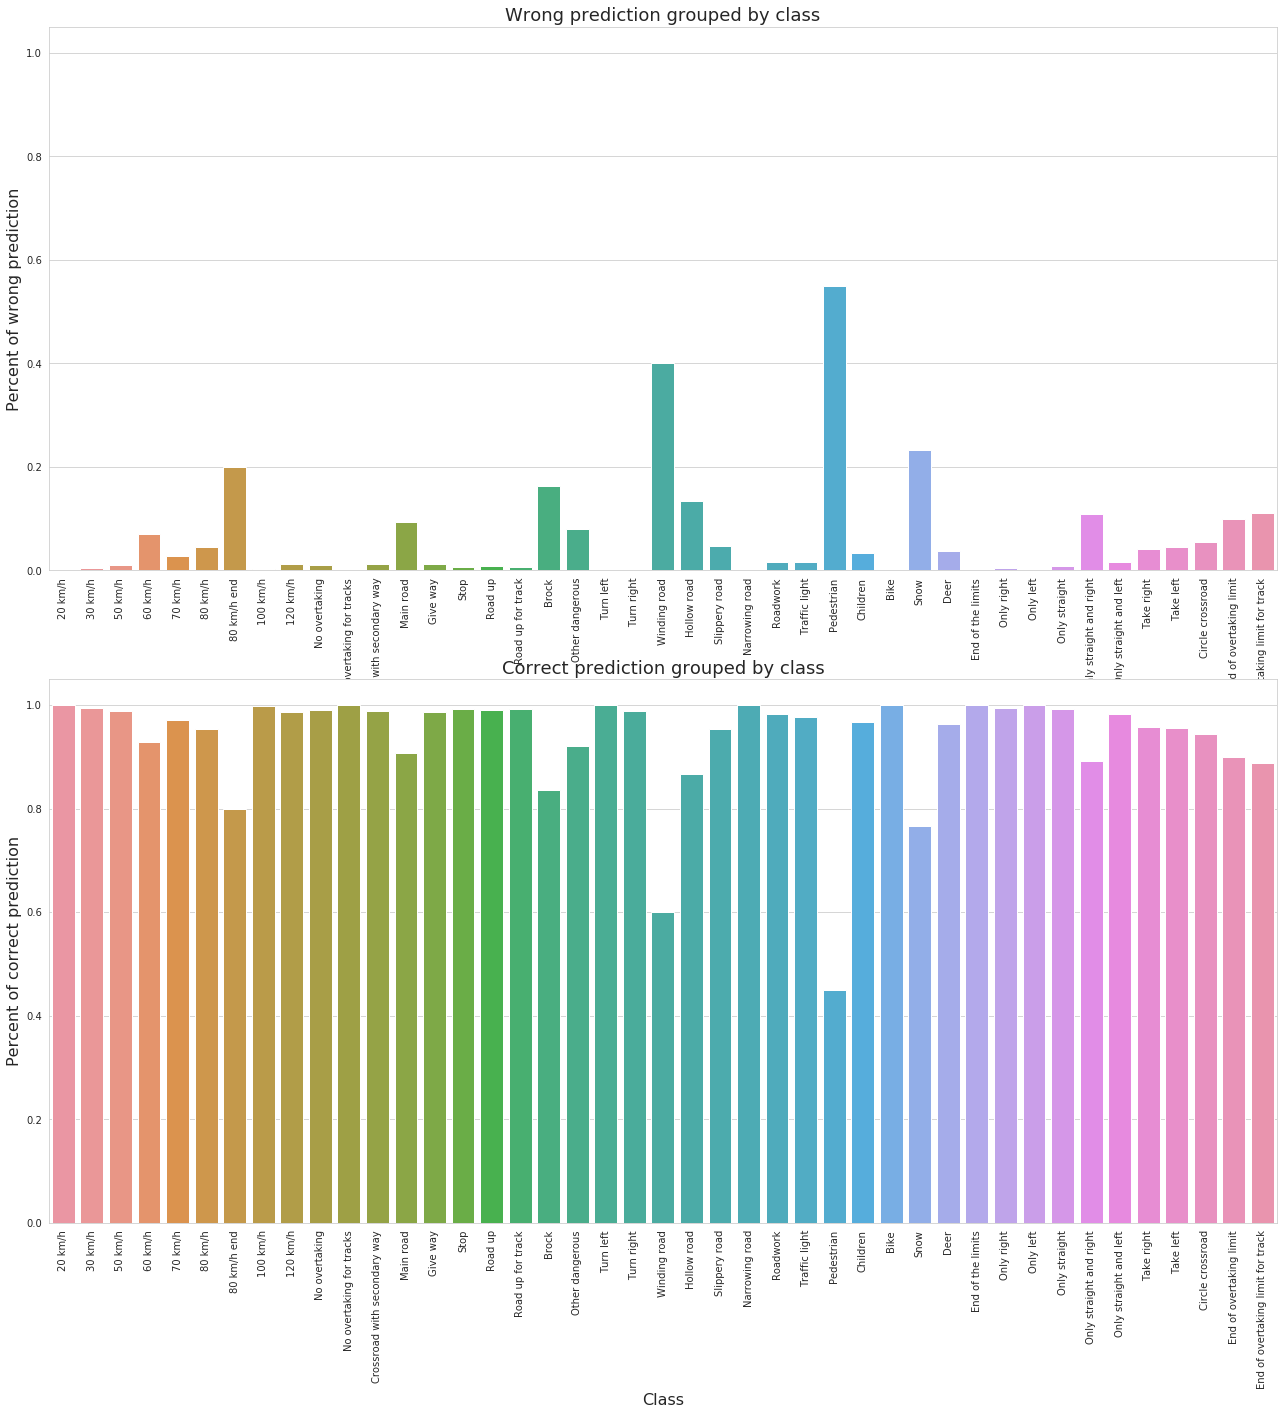

In [36]:
#Get prediction accuracy by class
correct_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Correct']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
correct_prediction_by_class_df = pd.DataFrame({'accuracy': correct_prediction_by_class, 'class': labels})

wrong_prediction_by_class = analys_df[analys_df['prediction_type'] == 'Wrong']['gt'].value_counts() / testDf['ClassId'].value_counts().sort_index()
wrong_prediction_by_class_df = pd.DataFrame({'error': wrong_prediction_by_class, 'class': labels})

#Plot distributions of correctly & wrong predicted classes
fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(22, 22))

sns.barplot(x='class', y='accuracy', data=correct_prediction_by_class_df, ax=axs[1])
sns.barplot(x='class', y='error', data=wrong_prediction_by_class_df, ax=axs[0])

axs[0].set_title('Wrong prediction grouped by class', fontsize=18)
axs[0].set_xlabel('Class', fontsize=16)
axs[0].set_ylabel('Percent of wrong prediction', fontsize=16)
axs[0].set_xticklabels(rotation=90, labels=labels)

axs[1].set_title('Correct prediction grouped by class', fontsize=18)
axs[1].set_xlabel('Class', fontsize=16)
axs[1].set_ylabel('Percent of correct prediction', fontsize=16)
axs[1].set_xticklabels(rotation=90, labels=labels)

plt.show()

### Confidence Analysis 
Classification neural networks produce not only discrete prediction. Model is also generated probability for each class (provided by softmax layer).

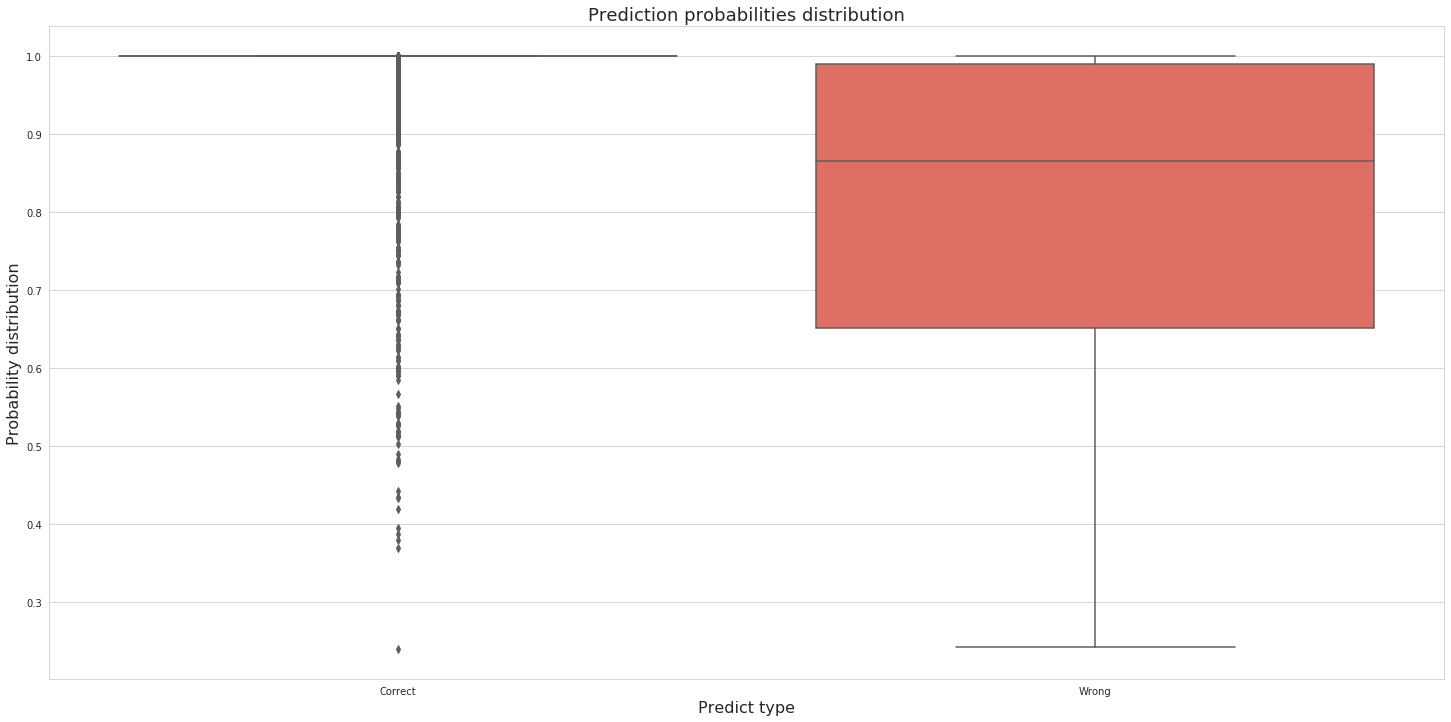

In [37]:
#Build confidence level distribution
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25,12))

sns.boxplot(x='prediction_type', y='prediction_probas', data=analys_df, ax=axs, palette=['#7cbd79','#f25e50']);
axs.set_title('Prediction probabilities distribution', fontsize=18);
axs.set_xlabel('Predict type', fontsize=16)
axs.set_ylabel('Probability distribution', fontsize=16);

## Visualize filters & feature maps 
There are many method for convolutional neural network visualization in many papers. The simplest one is to visualize the image after each convolutional layer. So, we will need to store all results after each convolutional layers.

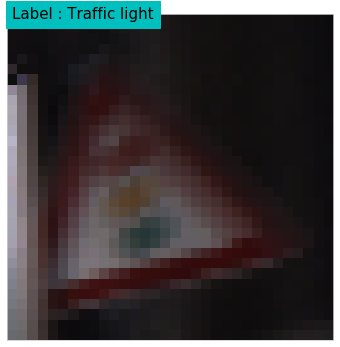

In [38]:
res = sess.run([load_img, load_label, conv1, conv2, conv3, conv4, conv5, conv6],
               feed_dict={dp_rate: 0,
                          manual_load: False,
                          img_placeholder: np.zeros([12,32,32,3])})
img, label = res[0], res[1]
img_visible = (img*255).astype(np.uint8)[0, :, :, :]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_visible)
ax.text(0, 0, 'Label : {}'.format(labels[label[0]]), color='k',backgroundcolor='c', fontsize=15) 
#ax.set_title(labels[label[0]])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

filters = res[2:]
layer_names = ['Convolutional layer {}'.format(x+1) for x in range(len(filters))]

Convolutional layers have many filters. Visualizing all images is very epxencive and hard, but we will try. Results after convolution is not normalized, so we will normalized it manualy. Visualization looks like heatmap but it is not heatmap. 

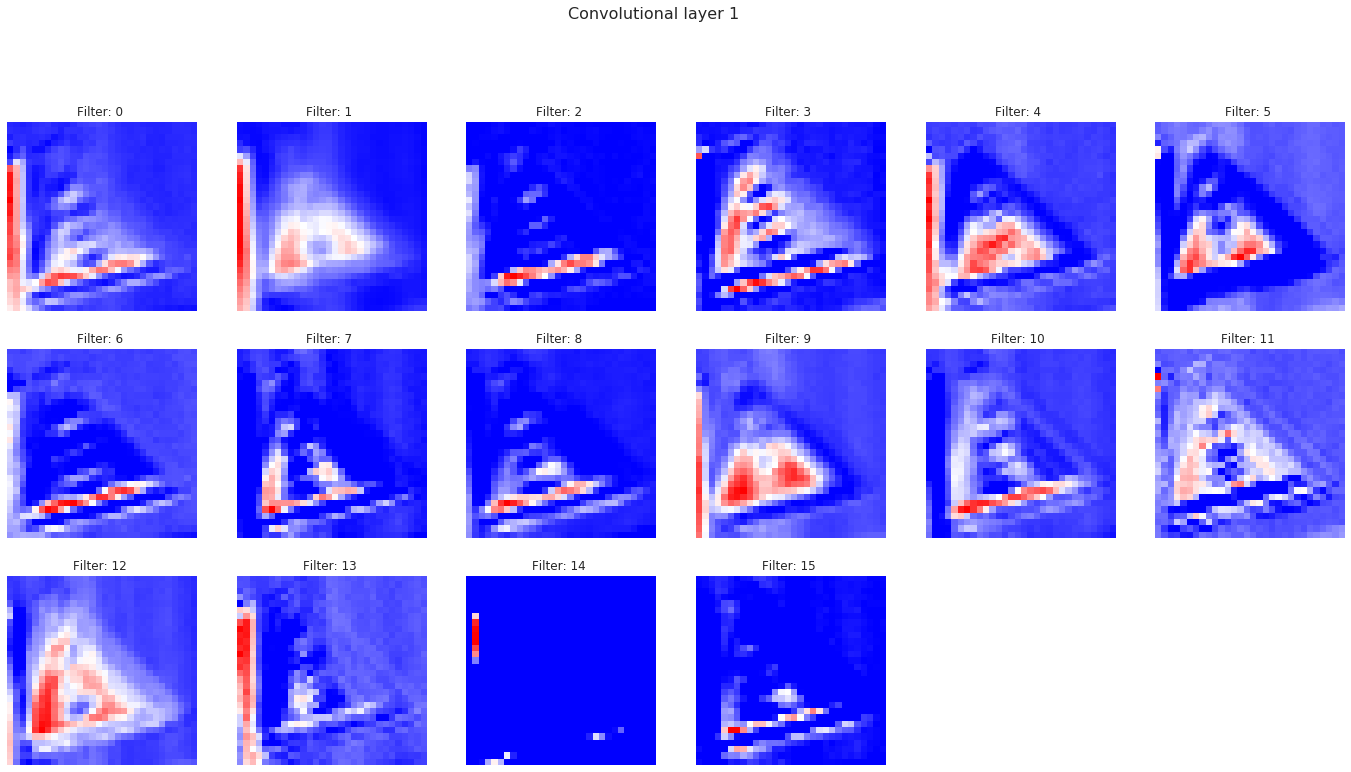

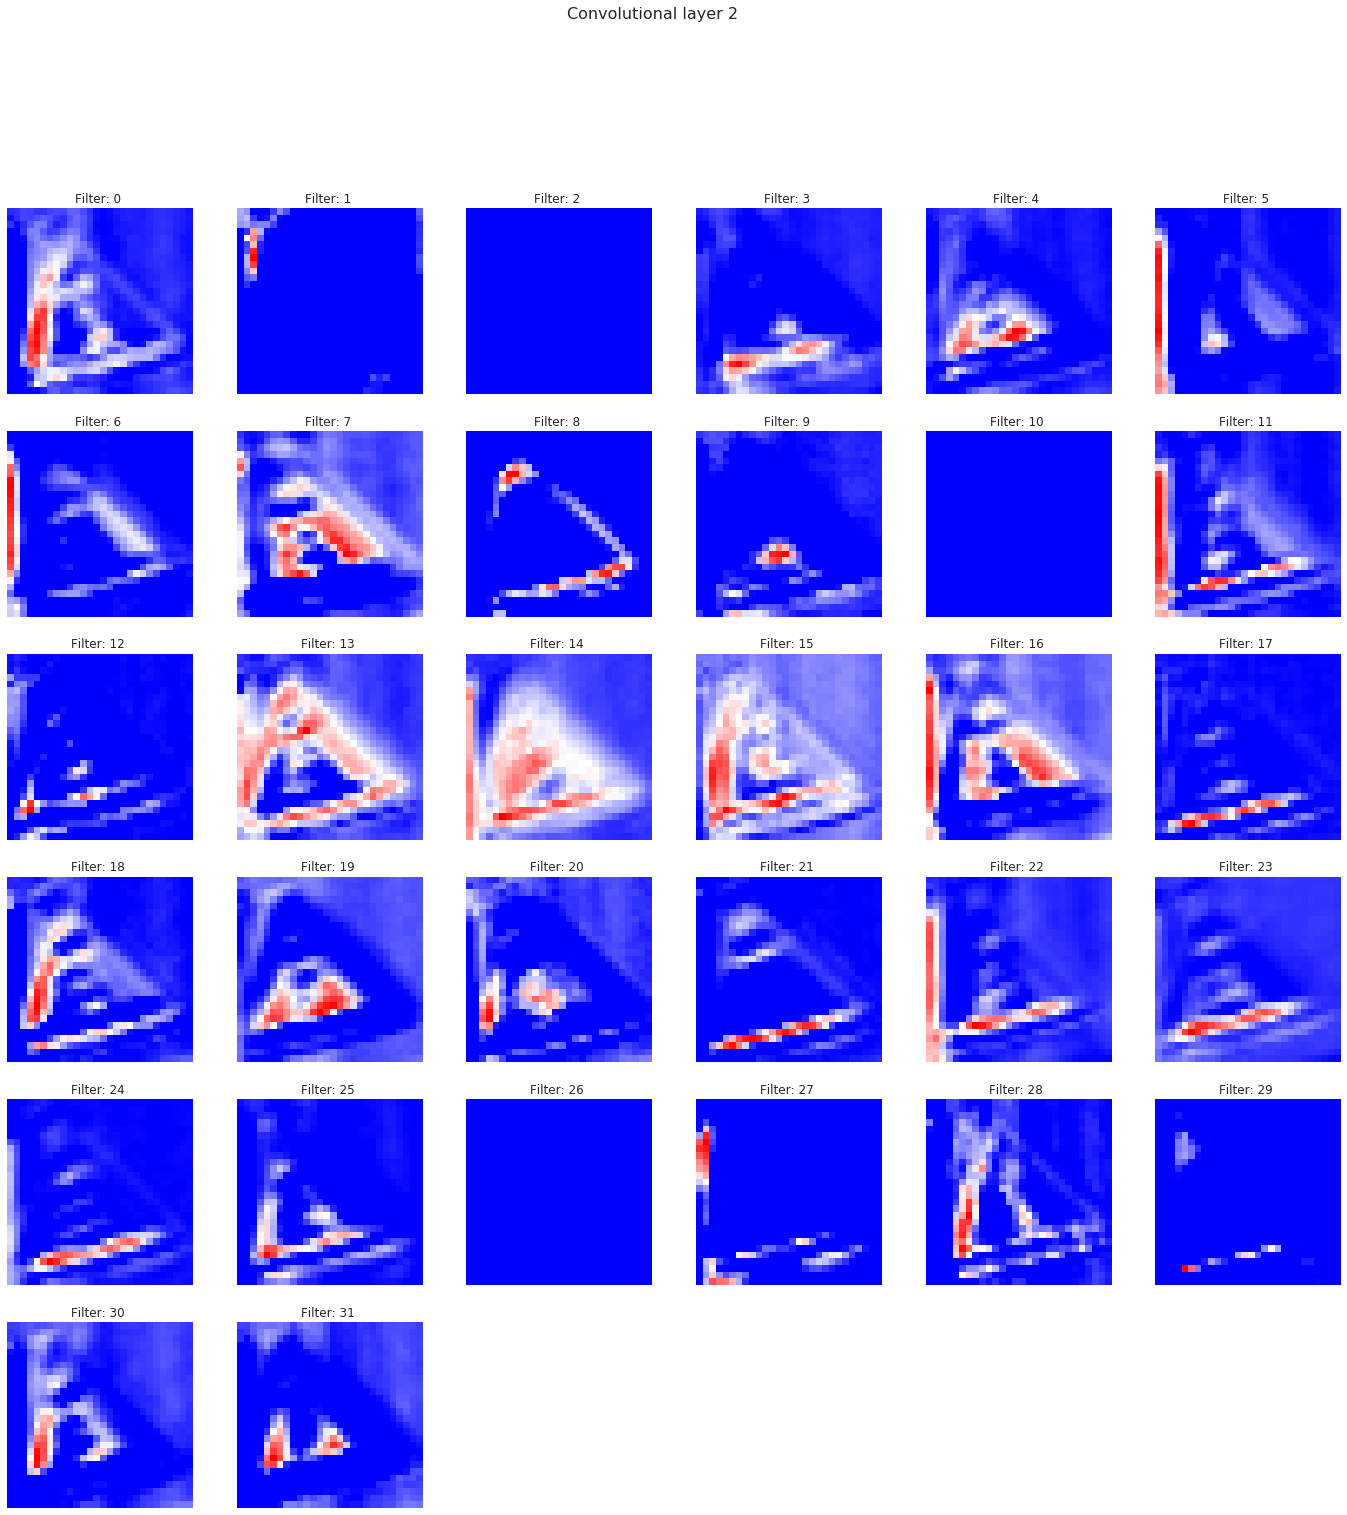

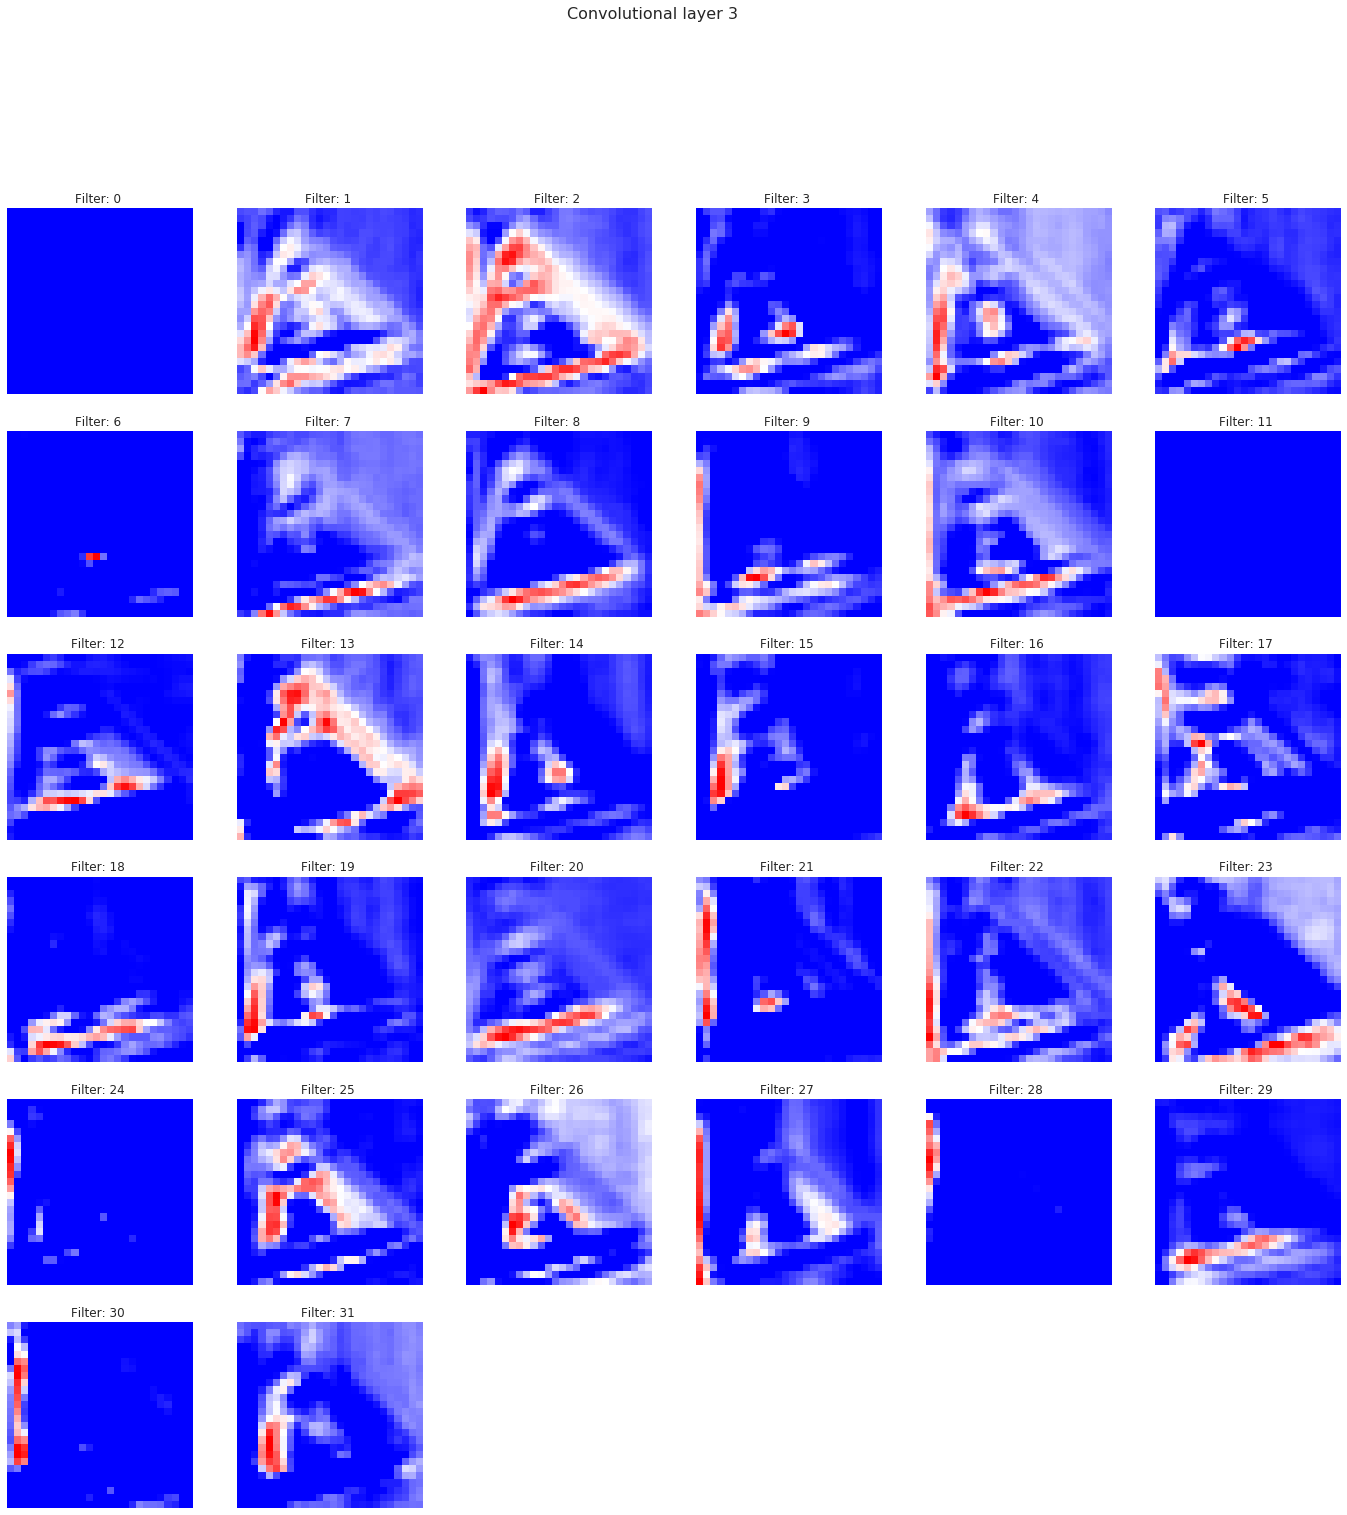

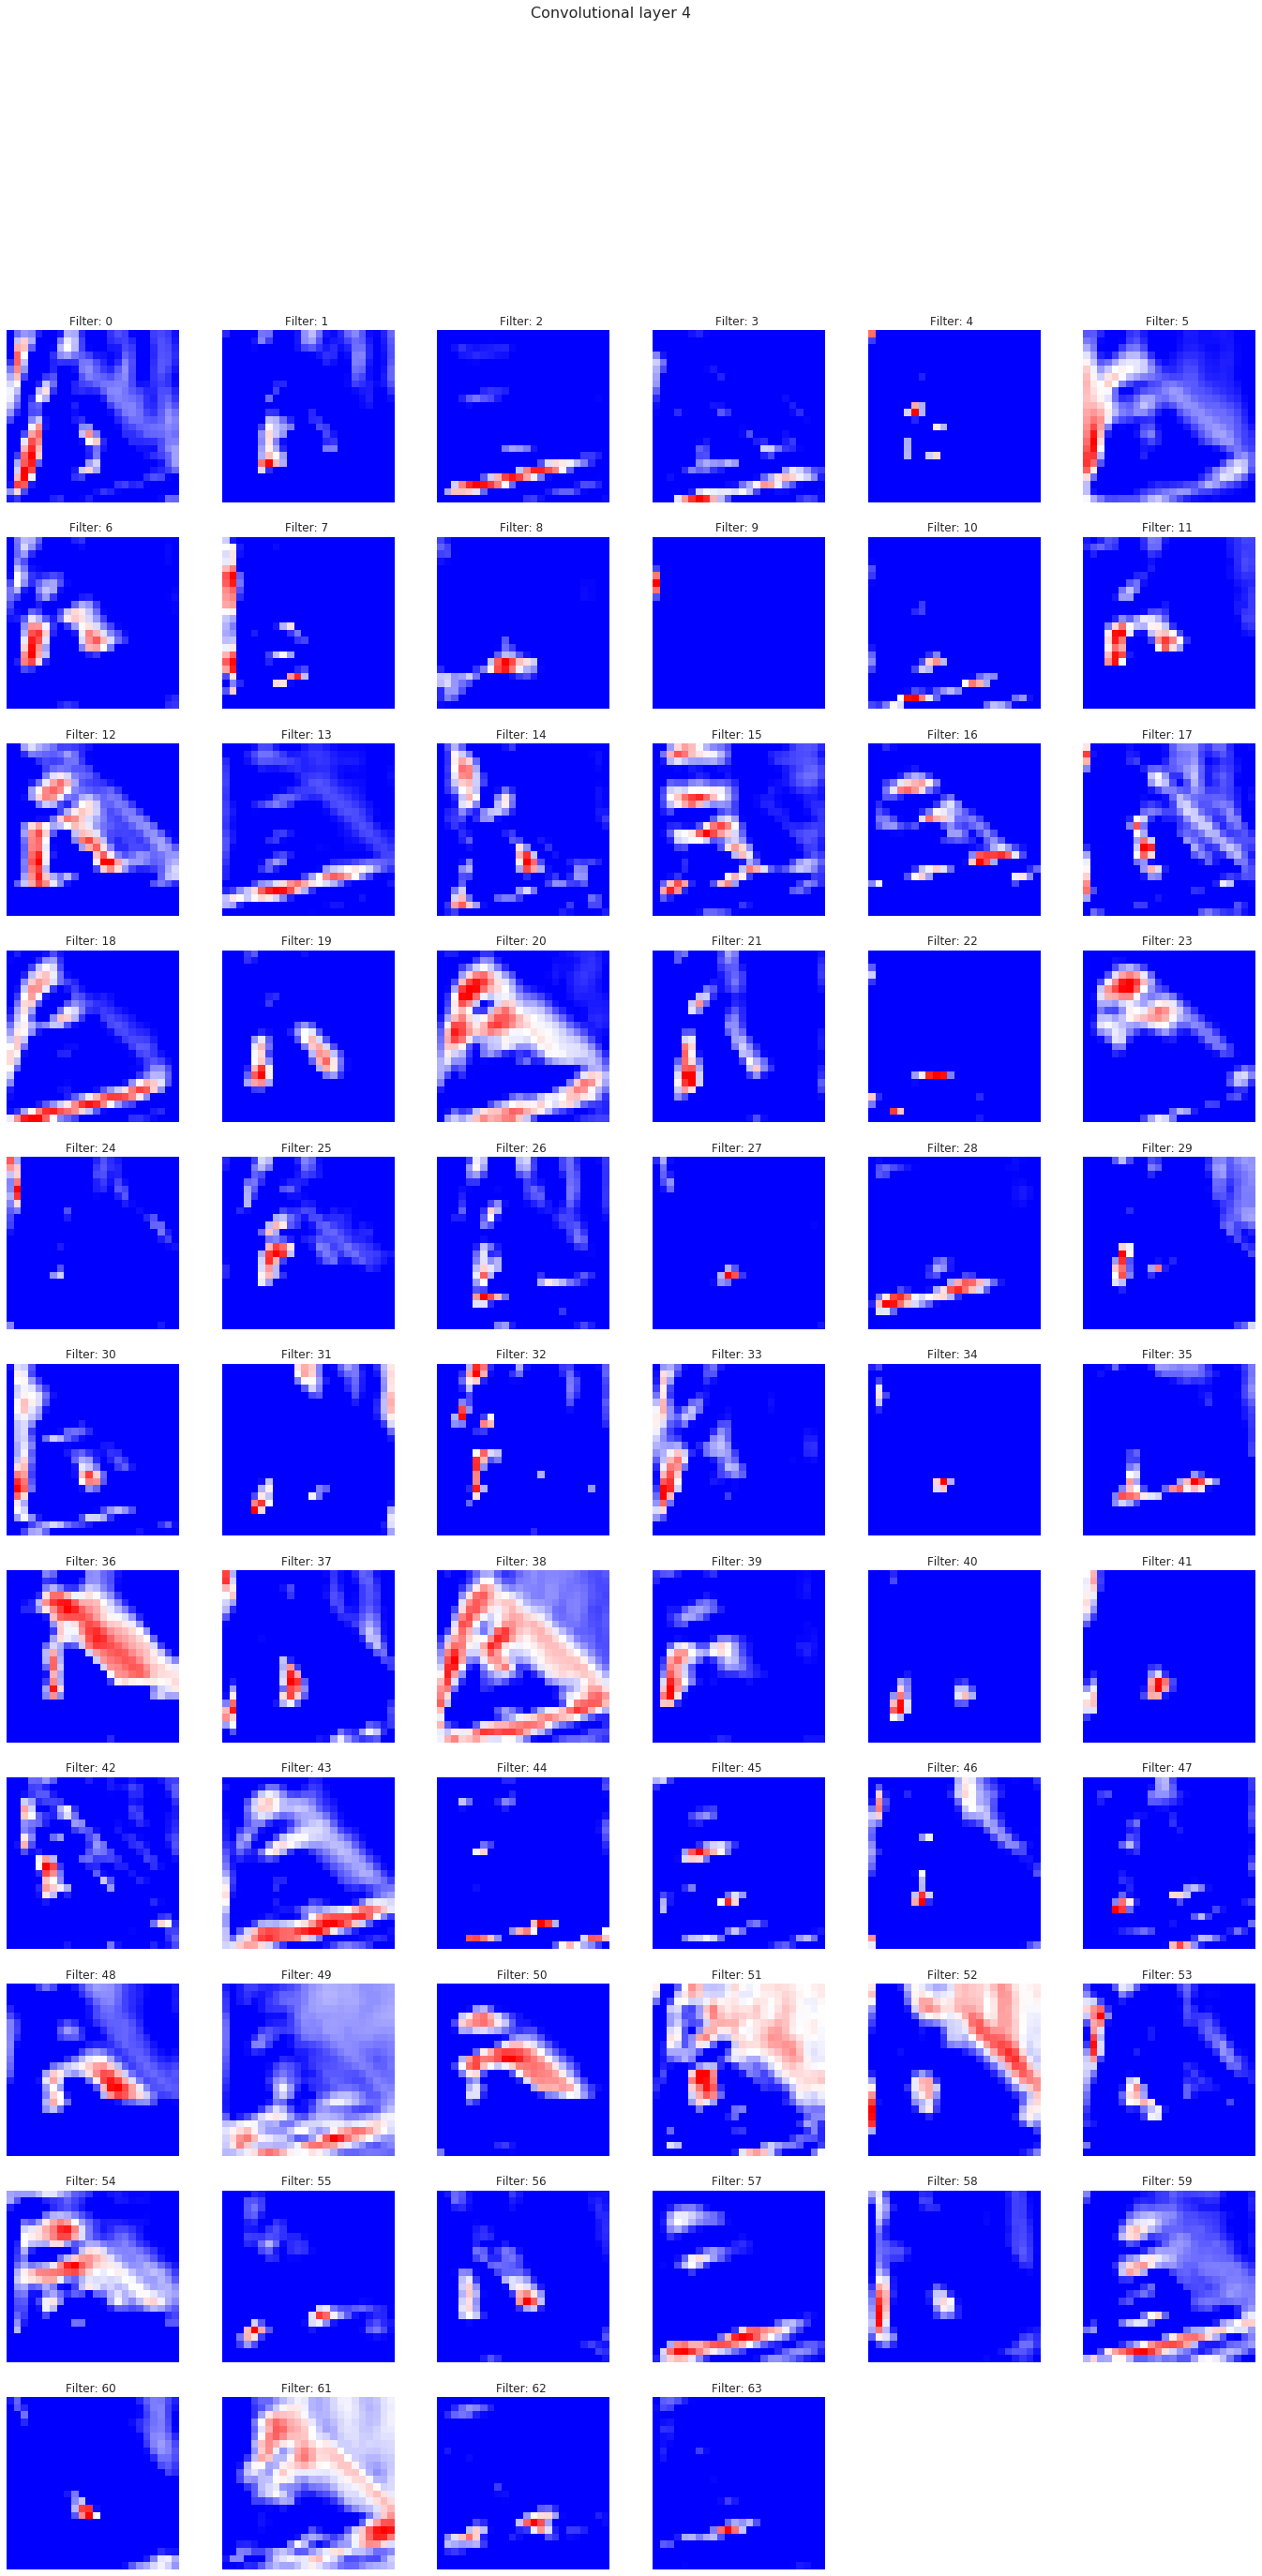

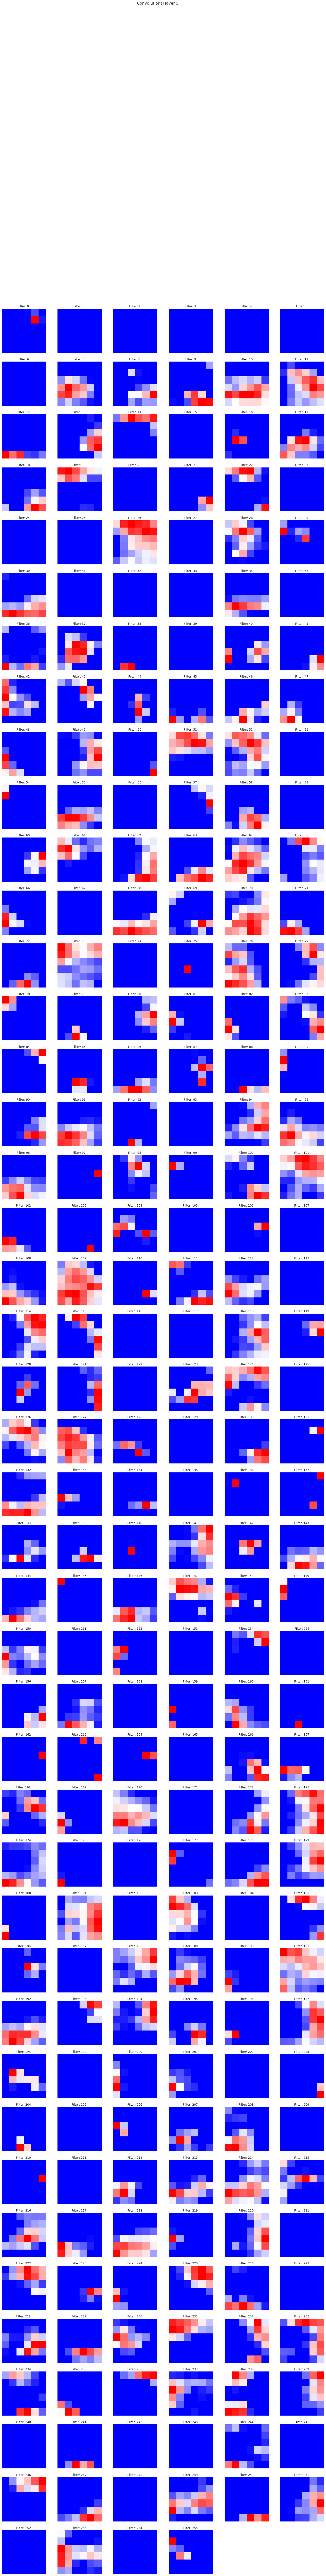

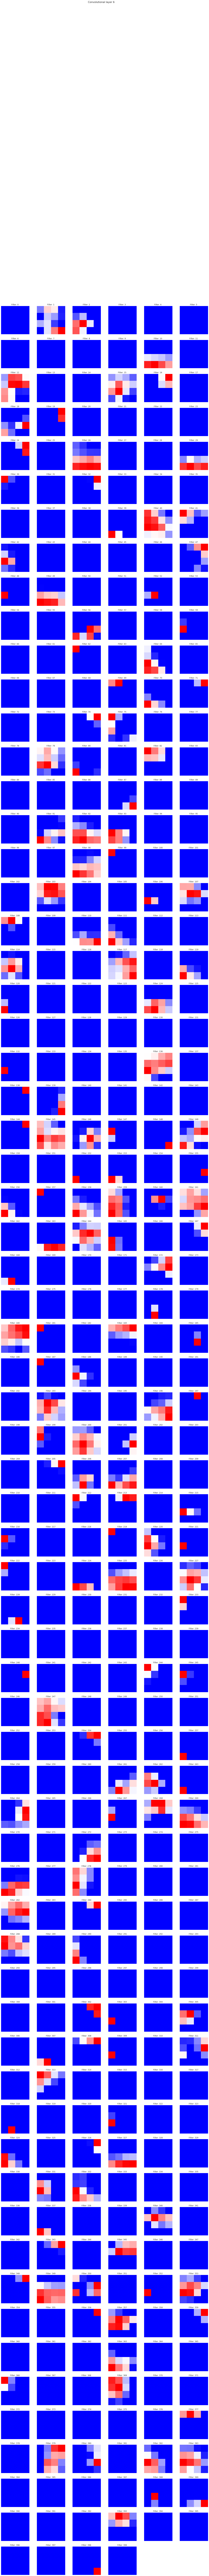

In [39]:
for filter_index in range(len(filters)):
    layers = filters[filter_index]
    filter_count = layers.shape[3]
    n_columns = 6
    n_rows = math.ceil(filter_count / n_columns) + 1
    fig = plt.figure(figsize=(24,n_rows*4));
    fig.suptitle(layer_names[filter_index], fontsize=16)
    for i in range(filter_count):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.title('Filter: {0} '.format(str(i)))
        plt.imshow(layers[0,:,:,i], interpolation="nearest", cmap='bwr')
    plt.show()

## Most important image parts for prediction
### Grad-CAM
A good way to understand what our model have learned is using Grad-CAM method. Grad-CAM is Gradient-weighted Class Activation Map. It helps us to explore which parts of image are important for prediction.

In [40]:
def Grad_CAM(sess, layer, predicted_class, nb_classes, img):
    conv_layer = layer
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(logits, one_hot)
    loss = tf.reduce_mean(signal)
    
    grads = tf.gradients(loss, conv_layer)[0]
    
    #Normalize gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={dp_rate: 0, manual_load: True,
                                                                     img_placeholder: img})
    output = output[0]           
    grads_val = grads_val[0]     

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    #Take a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    #Pass through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))

    #Convert grayscale to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

### Evaluate some samples and visualize Grad-CAM heatmaps

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


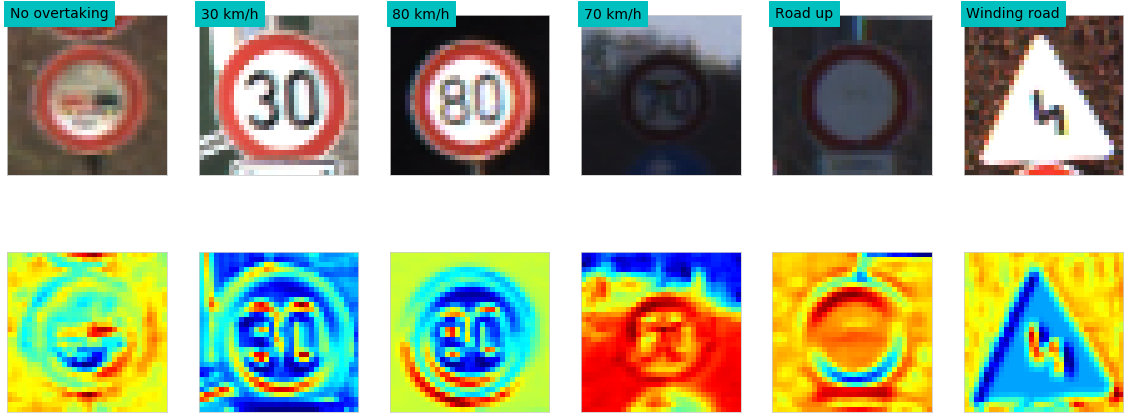

In [41]:
_img, _lb = sess.run([load_img, load_label])
grad_ipt = _img.copy()

samples = _img.shape[0]//2
fig, ax = plt.subplots(ncols=samples, nrows=2, figsize=(20, 8))
for i in range(samples):
    ax[0, i].imshow(_img[i, :, :, :])
    ax[0, i].text(0, 0, '{}'.format(labels[_lb[i]]), color='k',backgroundcolor='c', fontsize=14) 
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    #ax[0, i].set_title(labels[_lb[i]])
    
    image = _img[i, :, :, :]
    
    height = image.shape[0]
    width = image.shape[1]

    grad_ipt[0, :, :] = _img[i, :, :]
    heat_map = Grad_CAM(sess, conv1, _lb[i], 43, grad_ipt)
    #Resize heat map
    heat_map_resized = cv2.resize(heat_map, (height, width))

    #Normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)
    normalized_heat_map = cv2.applyColorMap((normalized_heat_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    
    ax[1, i].imshow(normalized_heat_map)
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)

## Conclusion 
This pipeline was very effective during the experimentations. In the end, the traffic sign classifier works pretty well overall with the test set. However, the network did not work as good with ramdom sample images from the internet.<br>
Moreover, if a self-driving car needs to find traffic signs in public, it first needs to know where the traffic signs are. For speeding signs, we may need an OCR (object recognition) mechanism that scan across the image with sliding windows to find the candidate signs. This kind of detection mechanism is not covered in this project.